In [1]:
# --- Basic Libraries ---
import pandas as pd
import numpy as np
import os
import re
import time
import warnings

# --- Plotting ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Machine Learning & NLP ---
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, roc_auc_score, classification_report)

# --- PyTorch & Transformers ---
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (DistilBertTokenizerFast, DistilBertForSequenceClassification,
                          AdamW, get_linear_schedule_with_warmup)

# --- Configuration ---
warnings.filterwarnings('ignore') # Suppress warnings for cleaner output
sns.set_style('darkgrid') # Set plot style

# --- Device Setup (Use GPU if available) ---
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

# --- Reproducibility ---
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# --- Constants ---
ISOT_DATA_PATH = 'data/isot_dataset/'
WELFAKE_DATA_PATH = 'data/welfake_dataset/'
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 256 # Max sequence length for BERT
BATCH_SIZE = 16 # Adjust based on GPU memory
EPOCHS_BERT = 2 # Number of training epochs for BERT (start low)
EPOCHS_BASELINE = 10 # Number of training epochs for baseline
LEARNING_RATE = 2e-5 # Learning rate for BERT fine-tuning

Using GPU: NVIDIA GeForce RTX 3070


## 1. Data Loading and Exploration (EDA)

Load both datasets and perform initial exploratory analysis to understand their structure, content, and potential differences.

In [3]:
# --- Load ISOT Dataset ---
# assumption: ISOT dataset has 'True.csv' and 'Fake.csv'
try:
    isot_true_df = pd.read_csv(os.path.join(ISOT_DATA_PATH, 'True.csv'))
    isot_fake_df = pd.read_csv(os.path.join(ISOT_DATA_PATH, 'Fake.csv'))

    # add labels: 0 for Real (True), 1 for Fake
    isot_true_df['label'] = 0
    isot_fake_df['label'] = 1

    # combine the true and fake dataframes
    isot_df = pd.concat([isot_true_df, isot_fake_df], ignore_index=True)

    # combine title and text - common practice for news classification
    # handle potential missing values or non-string types before concatenation
    isot_df['title'] = isot_df['title'].fillna('').astype(str)
    isot_df['text'] = isot_df['text'].fillna('').astype(str)
    isot_df['full_text'] = isot_df['title'] + ' ' + isot_df['text']

    # keep relevant columns
    isot_df = isot_df[['full_text', 'label']]

    print("ISOT Dataset Loaded Successfully:")
    print(f"Shape: {isot_df.shape}")
    print("\nFirst 5 rows:")
    print(isot_df.head())
    print("\nLabel Distribution:")
    print(isot_df['label'].value_counts(normalize=True))

except FileNotFoundError:
    print(f"Error: ISOT dataset files not found in {ISOT_DATA_PATH}")
    isot_df = pd.DataFrame() # Create empty df to avoid later errors

ISOT Dataset Loaded Successfully:
Shape: (44898, 2)

First 5 rows:
                                           full_text  label
0  As U.S. budget fight looms, Republicans flip t...      0
1  U.S. military to accept transgender recruits o...      0
2  Senior U.S. Republican senator: 'Let Mr. Muell...      0
3  FBI Russia probe helped by Australian diplomat...      0
4  Trump wants Postal Service to charge 'much mor...      0

Label Distribution:
label
1    0.522985
0    0.477015
Name: proportion, dtype: float64


In [4]:
# --- Load WELFake Dataset ---
# assumption: WELFake has 'WELFake_Dataset.csv' and labels are 0/1
try:
    welfake_df = pd.read_csv(os.path.join(WELFAKE_DATA_PATH, 'WELFake_Dataset.csv'))

    # check and handle potential unnamed columns
    if 'Unnamed: 0' in welfake_df.columns:
        welfake_df = welfake_df.drop(columns=['Unnamed: 0'])

    # combine title and text
    welfake_df['title'] = welfake_df['title'].fillna('').astype(str)
    welfake_df['text'] = welfake_df['text'].fillna('').astype(str)
    welfake_df['full_text'] = welfake_df['title'] + ' ' + welfake_df['text']

    # keep relevant columns (assuming label column exists and is 0/1)
    # Welfake uses 0 for fake, 1 for real - let's flip it to match ISOT (0=Real, 1=Fake)
    if 'label' in welfake_df.columns:
        welfake_df['label'] = 1 - welfake_df['label'] # Flip 0 -> 1, 1 -> 0
        welfake_df = welfake_df[['full_text', 'label']]
        print("\nWELFake Dataset Loaded Successfully:")
        print(f"Shape: {welfake_df.shape}")
        print("\nFirst 5 rows:")
        print(welfake_df.head())
        print("\nLabel Distribution (0=Real, 1=Fake):")
        print(welfake_df['label'].value_counts(normalize=True))
    else:
        print("Error: 'label' column not found in WELFake dataset.")
        welfake_df = pd.DataFrame()

except FileNotFoundError:
    print(f"Error: WELFake dataset file not found in {WELFAKE_DATA_PATH}")
    welfake_df = pd.DataFrame()


WELFake Dataset Loaded Successfully:
Shape: (72134, 2)

First 5 rows:
                                           full_text  label
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...      0
1     Did they post their votes for Hillary already?      0
2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...      0
3  Bobby Jindal, raised Hindu, uses story of Chri...      1
4  SATAN 2: Russia unvelis an image of its terrif...      0

Label Distribution (0=Real, 1=Fake):
label
0    0.514404
1    0.485596
Name: proportion, dtype: float64


In [5]:
# -*- coding: utf-8 -*-
"""
CM3060 Final Project: Fake News Detection

Goal: Develop a model to classify news articles as Real or Fake,
      robust across different datasets (ISOT and WELFake).

Challenge: Address potential domain shift issues where models trained on
           one dataset perform poorly on another.

Approach: Implement and evaluate an Ensemble method using DistilBERT,
          comparing it against individual specialist models and a baseline.

Label Convention: 1 = Real News, 0 = Fake News

Structure:
1. Data Loading & EDA
2. Data Preprocessing & Splitting
3. Baseline Model (TF-IDF + Logistic Regression)
4. BERT Model Setup (Tokenization, Datasets, Loaders)
5. BERT Training & Evaluation Functions
6. Train Model A (ISOT Specialist)
7. Train Model B (WELFake Specialist)
8. Ensemble Model Implementation & Evaluation
9. User Input Functionality
10. Analysis, Conclusion & Future Work
"""

# --- Core Libraries ---
import os
import re
import string
import time
import warnings

# --- Data Handling ---
import numpy as np
import pandas as pd

# --- Machine Learning ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score, roc_auc_score, roc_curve)

# --- Deep Learning (PyTorch & Transformers) ---
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import (DistilBertForSequenceClassification,
                          DistilBertTokenizer, AdamW,
                          get_linear_schedule_with_warmup)

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# --- Configuration ---
# Ignore simple warnings
warnings.filterwarnings("ignore")

# Set seed for reproducibility across libraries
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device setup (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Dataset Paths ---
# Adjust these paths if your folder structure or filenames differ
ISOT_DATA_PATH = 'data/isot_dataset'
WELFAKE_DATA_PATH = 'data/welfake_dataset'
ISOT_TRUE_FILE = os.path.join(ISOT_DATA_PATH, 'True.csv')
ISOT_FAKE_FILE = os.path.join(ISOT_DATA_PATH, 'Fake.csv')
WELFAKE_FILE = os.path.join(WELFAKE_DATA_PATH, 'WELFake_Dataset.csv') # Assuming this is the filename

# --- Model Configuration ---
BERT_MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 256 # Max sequence length for BERT
BATCH_SIZE = 16 # Reduce if you encounter memory issues
LEARNING_RATE = 2e-5
EPOCHS = 4 # Start with 1-2 epochs for faster testing, increase later (e.g., 3-5)

print("Setup Complete.")

Using device: cuda
Setup Complete.


In [6]:
# function to load isot dataset
# arguments:
# true_file_path - path to the CSV containing true news
# fake_file_path - path to the CSV containing fake news
# returns: pandas dataframe with combined isot data
def load_isot_dataset(true_file_path, fake_file_path):
    """Loads and combines True and Fake news from ISOT dataset files."""
    try:
        df_true = pd.read_csv(true_file_path)
        df_fake = pd.read_csv(fake_file_path)
        
        # Add label column: 1 for Real (True), 0 for Fake
        df_true['label'] = 1
        df_fake['label'] = 0
        
        # Combine dataframes
        df_isot = pd.concat([df_true, df_fake], ignore_index=True)
        
        # Add a source column
        df_isot['source'] = 'ISOT'
        
        print(f"ISOT Dataset: Loaded {len(df_true)} true and {len(df_fake)} fake articles.")
        return df_isot
    except FileNotFoundError as e:
        print(f"Error loading ISOT dataset: {e}. Please check file paths.")
        return pd.DataFrame() # Return empty DataFrame on error

# function to load welfake dataset
# arguments:
# file_path - path to the welfake CSV file
# returns: pandas dataframe with welfake data
def load_welfake_dataset(file_path):
    """Loads the WELFake dataset."""
    try:
        df_welfake = pd.read_csv(file_path)
        
        # WELFake uses 1 for real, 0 for fake (as per user note)
        # Let's ensure the label column is named 'label' for consistency
        if 'label' not in df_welfake.columns:
            # Try common alternative names or check structure if needed
            # For now, assume the column exists but might need renaming/checking
             if 'Label' in df_welfake.columns: # Check capitalization
                 df_welfake = df_welfake.rename(columns={'Label': 'label'})
             else:
                 # If you know the column index (e.g., it's the last one):
                 # label_col_index = -1 
                 # df_welfake = df_welfake.rename(columns={df_welfake.columns[label_col_index]: 'label'})
                 print("Warning: Could not automatically identify 'label' column in WELFake. Please inspect and adjust.")
                 # As a fallback, let's check the provided CSV structure for common names
                 # This part might need manual adjustment based on the exact WELFake file structure
                 if 'Unnamed: 0' in df_welfake.columns and df_welfake.columns[1] == 'title' :
                      # Heuristic: If first col is index, second title, maybe last is label?
                      if df_welfake.columns[-1] in [0,1]: # Check if last column looks like labels
                           df_welfake = df_welfake.rename(columns={df_welfake.columns[-1]: 'label'})
                           print("Attempted rename of last column to 'label'. Verify correctness.")
                      else:
                           print("Could not confidently identify label column.")
                 else:
                      # Default attempt assuming last col is label - REMOVE if incorrect
                      # df_welfake = df_welfake.rename(columns={df_welfake.columns[-1]: 'label'})
                      # print("Assuming last column is 'label'. Verify correctness.")
                      pass # Avoid making unsafe assumptions if structure unknown


        # Ensure labels are integers 0 or 1
        if 'label' in df_welfake.columns:
            df_welfake['label'] = df_welfake['label'].astype(int)
        else:
            print("Label column still not found. Manual intervention required.")
            return pd.DataFrame()

        # Remove potential unnamed index column often present
        if 'Unnamed: 0' in df_welfake.columns:
            df_welfake = df_welfake.drop(columns=['Unnamed: 0'])

        # Add a source column
        df_welfake['source'] = 'WELFake'

        print(f"WELFake Dataset: Loaded {len(df_welfake)} articles.")
        return df_welfake
    except FileNotFoundError as e:
        print(f"Error loading WELFake dataset: {e}. Please check file path.")
        return pd.DataFrame()

# --- Load the datasets ---
df_isot = load_isot_dataset(ISOT_TRUE_FILE, ISOT_FAKE_FILE)
df_welfake = load_welfake_dataset(WELFAKE_FILE)

# --- Display basic info ---
print("\n--- ISOT Dataset Info ---")
if not df_isot.empty:
    df_isot.info()
    print("\nISOT Value Counts:\n", df_isot['label'].value_counts())
else:
    print("ISOT DataFrame is empty.")

print("\n--- WELFake Dataset Info ---")
if not df_welfake.empty:
    df_welfake.info()
    print("\nWELFake Value Counts:\n", df_welfake['label'].value_counts())
else:
    print("WELFake DataFrame is empty.")

# --- Combine title and text ---
# Define a function to handle potential NaN values
def combine_text(title, text):
    title_str = str(title) if pd.notna(title) else ''
    text_str = str(text) if pd.notna(text) else ''
    # Add a space only if both title and text exist
    separator = ' ' if title_str and text_str else ''
    return title_str + separator + text_str

if not df_isot.empty:
    df_isot['full_text'] = df_isot.apply(lambda row: combine_text(row['title'], row['text']), axis=1)
    # Keep relevant columns
    df_isot = df_isot[['full_text', 'label', 'source']]

if not df_welfake.empty:
    # WELFake might have slightly different column names or structure
    # Ensure 'title' and 'text' columns exist before combining
    if 'title' in df_welfake.columns and 'text' in df_welfake.columns:
         df_welfake['full_text'] = df_welfake.apply(lambda row: combine_text(row['title'], row['text']), axis=1)
         # Keep relevant columns
         df_welfake = df_welfake[['full_text', 'label', 'source']]
    else:
         print("Warning: 'title' or 'text' columns not found in WELFake. Using only 'text' if available.")
         if 'text' in df_welfake.columns:
             df_welfake['full_text'] = df_welfake['text'].fillna('') # Handle potential NaNs in text
             df_welfake = df_welfake[['full_text', 'label', 'source']]
         else:
             print("Error: Neither 'text' nor 'title'+'text' combination possible for WELFake.")
             # Handle this case, maybe drop WELFake or stop execution
             df_welfake = pd.DataFrame() # Make it empty to prevent downstream errors


print("\nCombined 'title' and 'text' into 'full_text'.")
if not df_isot.empty:
    print("ISOT Head:\n", df_isot.head())
if not df_welfake.empty:
    print("WELFake Head:\n", df_welfake.head())

ISOT Dataset: Loaded 21417 true and 23481 fake articles.
WELFake Dataset: Loaded 72134 articles.

--- ISOT Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
 5   source   44898 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.1+ MB

ISOT Value Counts:
 label
0    23481
1    21417
Name: count, dtype: int64

--- WELFake Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    72095 non-null  object
 2   label   72134 non-null  int32 
 3   source  72134 non-null  

Applying basic cleaning to 'full_text'...


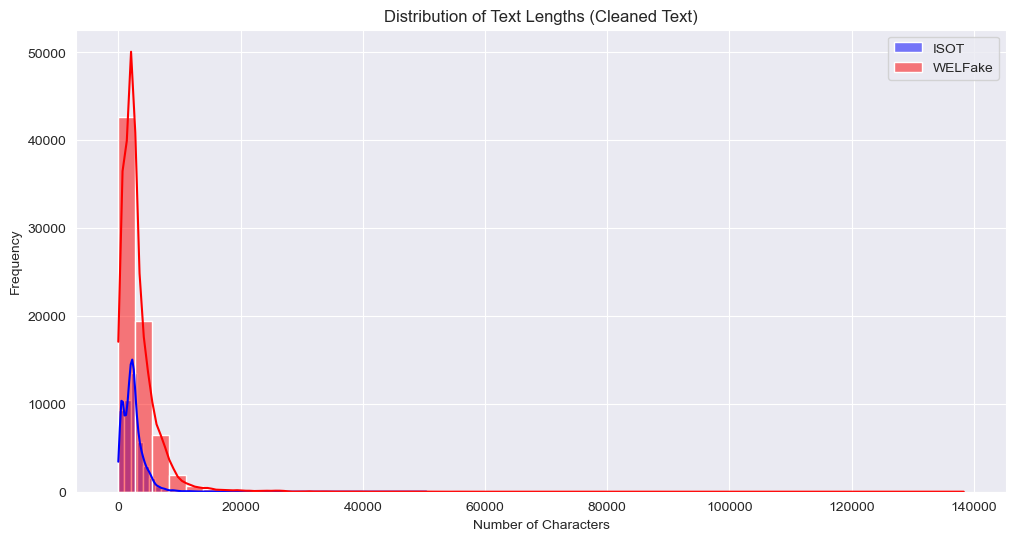


ISOT Text Length Stats:
 count    44898.000000
mean      2465.141654
std       2099.733822
min          0.000000
25%       1268.250000
50%       2195.000000
75%       3083.000000
max      50422.000000
Name: text_length, dtype: float64

WELFake Text Length Stats:
 count     72134.000000
mean       3215.491516
std        3592.502813
min           0.000000
25%        1383.250000
50%        2407.000000
75%        3979.000000
max      138343.000000
Name: text_length, dtype: float64


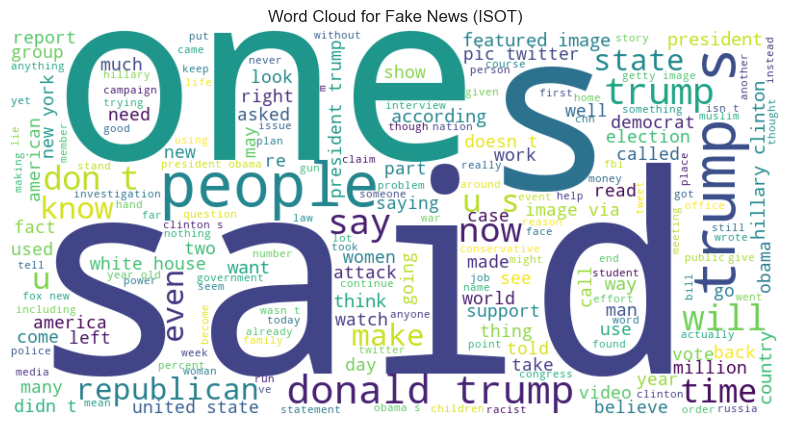

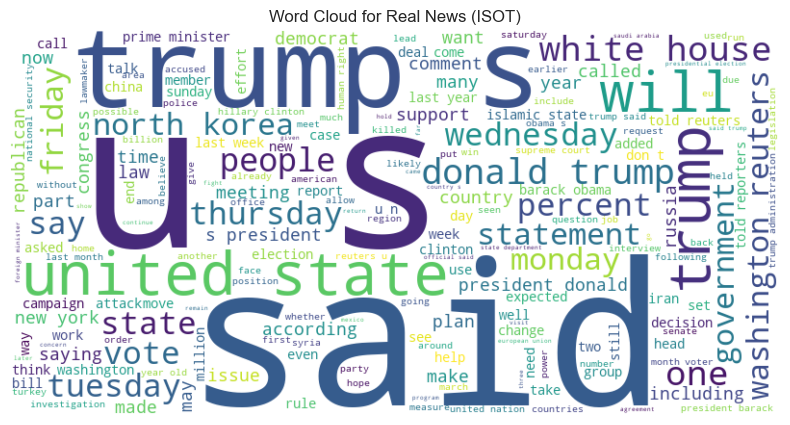

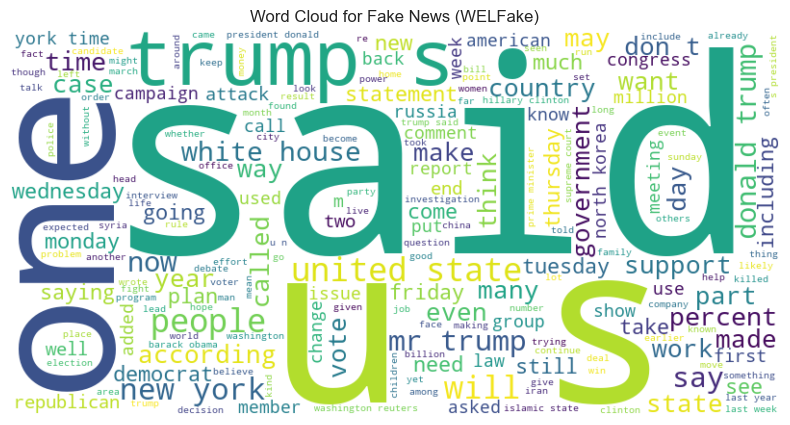

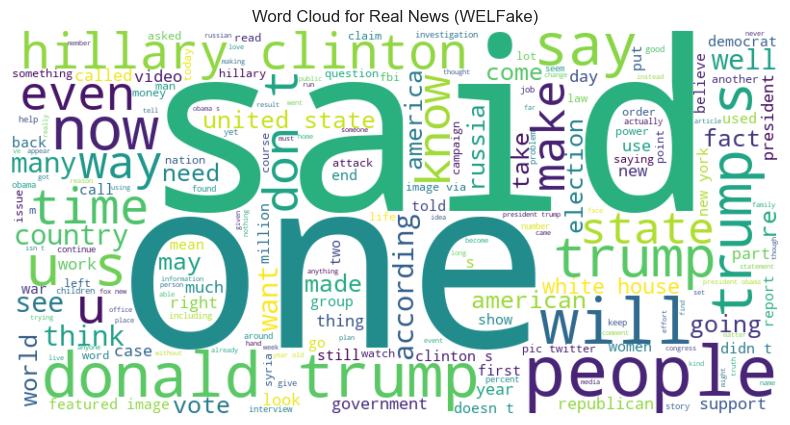


ISOT: Removed 10 articles with short/empty cleaned text.
WELFake: Removed 30 articles with short/empty cleaned text.

ISOT duplicates after cleaning: 5795
ISOT shape after dropping duplicates: (39093, 5)
WELFake duplicates after cleaning: 8481
WELFake shape after dropping duplicates: (63623, 5)

--- Final Data Balance ---
ISOT:
 label
1    0.542143
0    0.457857
Name: proportion, dtype: float64
WELFake:
 label
0    0.546783
1    0.453217
Name: proportion, dtype: float64

EDA completed.


In [7]:
# --- Basic Cleaning & EDA ---

# function to perform basic text cleaning
# arguments:
# text - input string
# returns: cleaned string
def clean_text(text):
    """Basic text cleaning: lowercase, remove punctuation, numbers, extra whitespace."""
    if not isinstance(text, str):
        return ''
    text = text.lower()
    # Keep spaces and basic alphanumeric characters. Remove punctuation more carefully.
    # Preserve apostrophes within words (like "don't") but remove leading/trailing ones.
    text = re.sub(r'\[.*?\]', '', text) # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove URLs
    text = re.sub(r'<.*?>+', '', text) # Remove HTML tags
    # Handle punctuation - remove it if it's not part of a word character sequence
    text = re.sub(r'[%s]' % re.escape(string.punctuation.replace("'", "")), ' ', text) # Remove punctuation except apostrophe
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    return text

print("Applying basic cleaning to 'full_text'...")
if not df_isot.empty:
    df_isot['cleaned_text'] = df_isot['full_text'].apply(clean_text)
if not df_welfake.empty:
    df_welfake['cleaned_text'] = df_welfake['full_text'].apply(clean_text)

# --- Analyze Text Lengths ---
if not df_isot.empty:
    df_isot['text_length'] = df_isot['cleaned_text'].apply(len)
if not df_welfake.empty:
    df_welfake['text_length'] = df_welfake['cleaned_text'].apply(len)

plt.figure(figsize=(12, 6))

if not df_isot.empty:
    sns.histplot(df_isot['text_length'], bins=50, kde=True, label='ISOT', color='blue')
if not df_welfake.empty:
    sns.histplot(df_welfake['text_length'], bins=50, kde=True, label='WELFake', color='red')

plt.title('Distribution of Text Lengths (Cleaned Text)')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.legend()
plt.show()

if not df_isot.empty:
    print("\nISOT Text Length Stats:\n", df_isot['text_length'].describe())
if not df_welfake.empty:
    print("\nWELFake Text Length Stats:\n", df_welfake['text_length'].describe())


# --- Word Clouds (Optional - can be slow on large datasets) ---
def generate_word_cloud(df, label_val, label_name, source_name):
    """Generates a word cloud for text based on label."""
    text = ' '.join(df[df['label'] == label_val]['cleaned_text'])
    if not text:
        print(f"No text found for {label_name} news in {source_name}.")
        return
    try:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {label_name} News ({source_name})')
        plt.show()
    except ValueError as e:
         print(f"Could not generate word cloud for {label_name} in {source_name} (likely empty text after filtering): {e}")


# Generate word clouds if dataframes are not empty
# Consider sampling if datasets are very large to speed this up: df.sample(10000)
if not df_isot.empty:
    # Sample ISOT if it's too large
    sample_isot = df_isot # Or df_isot.sample(min(len(df_isot), 20000), random_state=SEED) if needed
    generate_word_cloud(sample_isot, 0, 'Fake', 'ISOT')
    generate_word_cloud(sample_isot, 1, 'Real', 'ISOT')

if not df_welfake.empty:
    # Sample WELFake if it's too large
    sample_welfake = df_welfake # Or df_welfake.sample(min(len(df_welfake), 20000), random_state=SEED) if needed
    generate_word_cloud(sample_welfake, 0, 'Fake', 'WELFake')
    generate_word_cloud(sample_welfake, 1, 'Real', 'WELFake')

# --- Drop rows with very short or empty cleaned text ---
# This helps avoid issues with vectorizers or models
if not df_isot.empty:
    initial_len = len(df_isot)
    df_isot = df_isot[df_isot['cleaned_text'].str.len() > 10] # Keep texts longer than 10 chars
    print(f"\nISOT: Removed {initial_len - len(df_isot)} articles with short/empty cleaned text.")

if not df_welfake.empty:
    initial_len = len(df_welfake)
    df_welfake = df_welfake[df_welfake['cleaned_text'].str.len() > 10] # Keep texts longer than 10 chars
    print(f"WELFake: Removed {initial_len - len(df_welfake)} articles with short/empty cleaned text.")

# --- Check for duplicates again after cleaning and combining ---
if not df_isot.empty:
    print(f"\nISOT duplicates after cleaning: {df_isot.duplicated(subset=['cleaned_text', 'label']).sum()}")
    df_isot = df_isot.drop_duplicates(subset=['cleaned_text', 'label'], keep='first')
    print(f"ISOT shape after dropping duplicates: {df_isot.shape}")

if not df_welfake.empty:
    print(f"WELFake duplicates after cleaning: {df_welfake.duplicated(subset=['cleaned_text', 'label']).sum()}")
    df_welfake = df_welfake.drop_duplicates(subset=['cleaned_text', 'label'], keep='first')
    print(f"WELFake shape after dropping duplicates: {df_welfake.shape}")


# --- Final check on data balance ---
print("\n--- Final Data Balance ---")
if not df_isot.empty:
    print("ISOT:\n", df_isot['label'].value_counts(normalize=True))
if not df_welfake.empty:
    print("WELFake:\n", df_welfake['label'].value_counts(normalize=True))

print("\nEDA completed.")

In [8]:
# --- Splitting Data ---
# We need separate splits for ISOT and WELFake to train specialist models
# and evaluate cross-dataset generalization.

# function to split dataset
# arguments:
# df - dataframe to split
# test_size - proportion for test set (default 0.2)
# val_size_of_train - proportion of training set to use for validation (default 0.1)
# stratify_col - column name to stratify on (default 'label')
# random_state - seed for reproducibility
# returns: train_df, val_df, test_df
def split_data(df, test_size=0.2, val_size_of_train=0.1, stratify_col='label', random_state=SEED):
    """Splits dataframe into train, validation, and test sets."""
    if df.empty or stratify_col not in df.columns:
        print(f"Cannot split empty DataFrame or missing stratify column '{stratify_col}'.")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    # Ensure stratification is possible (at least 2 samples per class)
    counts = df[stratify_col].value_counts()
    if (counts < 2).any():
        print(f"Warning: Some classes in '{stratify_col}' have less than 2 samples. Stratification might fail or be imperfect.")
        # Fallback to non-stratified split if necessary, though less ideal
        stratify_values = None # Or df[stratify_col] if you want to try anyway
    else:
        stratify_values = df[stratify_col]


    # Split into Train+Validation and Test
    train_val_df, test_df = train_test_split(
        df,
        test_size=test_size,
        random_state=random_state,
        stratify=stratify_values
    )

    # Split Train+Validation into Train and Validation
    # Adjust validation size relative to the original df size
    val_size_adjusted = val_size_of_train / (1 - test_size)

    # Ensure stratification is possible for the second split
    train_val_counts = train_val_df[stratify_col].value_counts()
    if (train_val_counts < 2).any():
         print(f"Warning: Stratification for val split might fail (classes < 2).")
         stratify_train_val = None
    else:
         stratify_train_val = train_val_df[stratify_col]


    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_size_adjusted,
        random_state=random_state,
        stratify=stratify_train_val
    )

    print(f"Split sizes: Train={len(train_df)}, Validation={len(val_df)}, Test={len(test_df)}")
    return train_df, val_df, test_df

# --- Perform splits for each dataset ---
df_isot_train, df_isot_val, df_isot_test = split_data(df_isot)
df_welfake_train, df_welfake_val, df_welfake_test = split_data(df_welfake)

# --- Combine training data for the baseline ---
# Only combine if both dataframes were successfully loaded and split
if not df_isot_train.empty and not df_welfake_train.empty:
    df_combined_train = pd.concat([df_isot_train, df_welfake_train], ignore_index=True)
    print(f"\nCombined training set size: {len(df_combined_train)}")
    # Shuffle combined training data
    df_combined_train = df_combined_train.sample(frac=1, random_state=SEED).reset_index(drop=True)
elif not df_isot_train.empty:
    print("\nUsing only ISOT for combined training (WELFake missing/empty).")
    df_combined_train = df_isot_train.copy()
elif not df_welfake_train.empty:
    print("\nUsing only WELFake for combined training (ISOT missing/empty).")
    df_combined_train = df_welfake_train.copy()
else:
    print("\nError: Both ISOT and WELFake training sets are empty. Cannot create combined set.")
    df_combined_train = pd.DataFrame()

print("Data splitting complete.")

Split sizes: Train=27364, Validation=3910, Test=7819
Split sizes: Train=44535, Validation=6363, Test=12725

Combined training set size: 71899
Data splitting complete.


Setting up baseline model (TF-IDF + Logistic Regression)...
Fitting TF-IDF on combined training data...
TF-IDF Training Matrix shape: (71899, 10000)
Training Logistic Regression model...
Baseline model trained.

--- Evaluating Baseline (TF-IDF + LogReg) on ISOT Test ---
Accuracy:  0.3740
Precision: 0.4128
Recall:    0.3661
F1-Score:  0.3880
ROC AUC:   0.3278

Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.38      0.36      3580
           1       0.41      0.37      0.39      4239

    accuracy                           0.37      7819
   macro avg       0.38      0.37      0.37      7819
weighted avg       0.38      0.37      0.37      7819



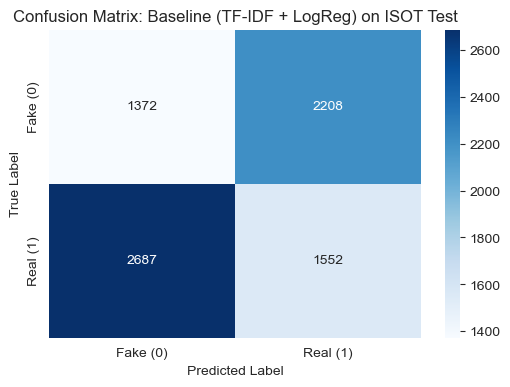

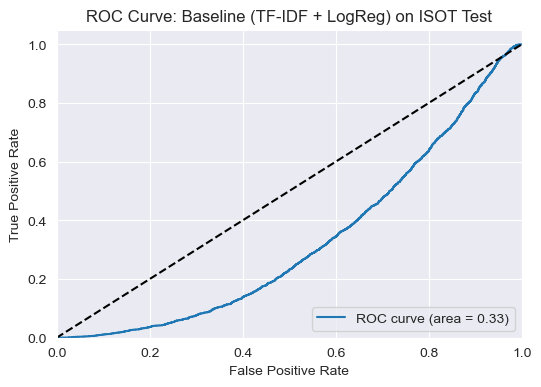


--- Evaluating Baseline (TF-IDF + LogReg) on WELFake Test ---
Accuracy:  0.6358
Precision: 0.5944
Recall:    0.6182
F1-Score:  0.6060
ROC AUC:   0.7265

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.65      0.66      6958
           1       0.59      0.62      0.61      5767

    accuracy                           0.64     12725
   macro avg       0.63      0.63      0.63     12725
weighted avg       0.64      0.64      0.64     12725



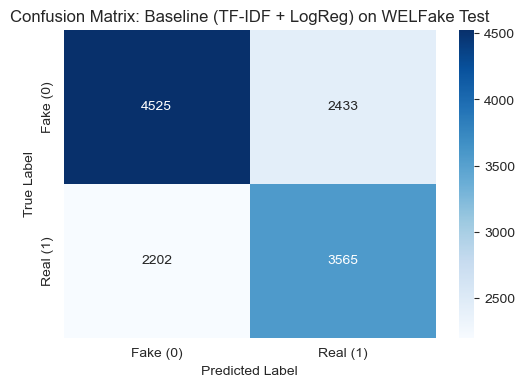

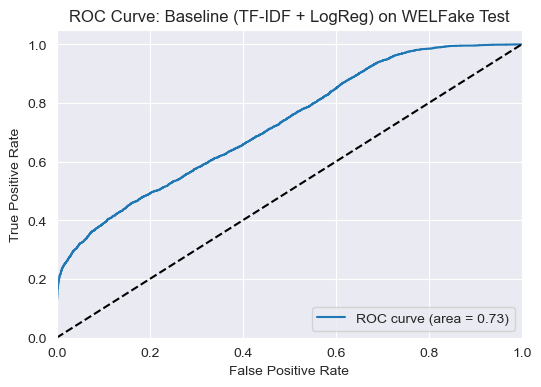

In [9]:
# --- Baseline Model: TF-IDF + Logistic Regression ---

print("Setting up baseline model (TF-IDF + Logistic Regression)...")

if not df_combined_train.empty:
    # --- Initialize TF-IDF Vectorizer ---
    # Use cleaned text
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000) # Limit features

    # Fit on combined training data and transform
    print("Fitting TF-IDF on combined training data...")
    X_train_tfidf = tfidf_vectorizer.fit_transform(df_combined_train['cleaned_text'])
    y_train = df_combined_train['label']
    print(f"TF-IDF Training Matrix shape: {X_train_tfidf.shape}")

    # Transform validation and test sets
    # Important: Use transform(), not fit_transform(), on test/val data
    X_isot_test_tfidf = tfidf_vectorizer.transform(df_isot_test['cleaned_text']) if not df_isot_test.empty else None
    X_welfake_test_tfidf = tfidf_vectorizer.transform(df_welfake_test['cleaned_text']) if not df_welfake_test.empty else None

    y_isot_test = df_isot_test['label'] if not df_isot_test.empty else None
    y_welfake_test = df_welfake_test['label'] if not df_welfake_test.empty else None


    # --- Train Logistic Regression Model ---
    print("Training Logistic Regression model...")
    baseline_model = LogisticRegression(solver='liblinear', random_state=SEED, C=1.0) # C is regularization strength
    baseline_model.fit(X_train_tfidf, y_train)
    print("Baseline model trained.")

    # --- Evaluate Baseline Model ---
    # function to evaluate a model
    # arguments:
    # model - the trained model
    # X_test - features of the test set
    # y_test - true labels of the test set
    # model_name - name of the model for printing
    # dataset_name - name of the dataset being tested
    # returns: dictionary with evaluation metrics
    def evaluate_model(model, X_test, y_test, model_name="Model", dataset_name="Test Set"):
        """Calculates and prints evaluation metrics for a model."""
        if X_test is None or y_test is None:
             print(f"Skipping evaluation for {model_name} on {dataset_name}: Missing data.")
             return None

        print(f"\n--- Evaluating {model_name} on {dataset_name} ---")
        try:
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of class 1 (Real)

            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            try:
                roc_auc = roc_auc_score(y_test, y_pred_proba)
            except ValueError as e:
                 # Handle cases where only one class is present in y_test or y_pred_proba
                 print(f"Could not calculate ROC AUC for {dataset_name}: {e}. Setting to 0.0")
                 roc_auc = 0.0


            print(f"Accuracy:  {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall:    {recall:.4f}")
            print(f"F1-Score:  {f1:.4f}")
            print(f"ROC AUC:   {roc_auc:.4f}")
            print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
            # print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred)) # Optional: can print matrix too

            # Plot Confusion Matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(6, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake (0)', 'Real (1)'], yticklabels=['Fake (0)', 'Real (1)'])
            plt.title(f'Confusion Matrix: {model_name} on {dataset_name}')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

            # Plot ROC Curve
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            plt.figure(figsize=(6, 4))
            plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve: {model_name} on {dataset_name}')
            plt.legend(loc="lower right")
            plt.show()


            return {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'roc_auc': roc_auc
            }
        except Exception as e:
            print(f"Error during evaluation of {model_name} on {dataset_name}: {e}")
            return None

    # Evaluate on both test sets
    baseline_results_isot = evaluate_model(baseline_model, X_isot_test_tfidf, y_isot_test, "Baseline (TF-IDF + LogReg)", "ISOT Test")
    baseline_results_welfake = evaluate_model(baseline_model, X_welfake_test_tfidf, y_welfake_test, "Baseline (TF-IDF + LogReg)", "WELFake Test")

    baseline_results = {
        "ISOT": baseline_results_isot,
        "WELFake": baseline_results_welfake
    }
else:
    print("Skipping baseline model: Combined training data is empty.")
    baseline_model = None
    baseline_results = {"ISOT": None, "WELFake": None}

In [10]:
# --- BERT Setup ---

print(f"Loading DistilBERT tokenizer: {BERT_MODEL_NAME}")
tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL_NAME)

# --- Custom Dataset Class ---
# This class formats the data correctly for BERT
class NewsDataset(Dataset):
    # constructor
    # arguments:
    # texts - list or series of text strings
    # labels - list or series of labels (0 or 1)
    # tokenizer - the BERT tokenizer instance
    # max_len - maximum sequence length for padding/truncation
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    # get item count
    def __len__(self):
        return len(self.texts)

    # get item by index
    # arguments:
    # item - index of the item to retrieve
    # returns: dictionary with tokenized input_ids, attention_mask, and labels
    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,    # Add '[CLS]' and '[SEP]'
            max_length=self.max_len,    # Pad & truncate
            padding='max_length',       # Pad to max_length
            truncation=True,            # Truncate to max_length
            return_attention_mask=True, # Create attention masks
            return_tensors='pt',        # Return PyTorch tensors
        )

        return {
            'text': text, # Keep original text for reference if needed
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# --- Create PyTorch Datasets ---
# function to create a dataset object
# arguments:
# df - dataframe containing 'cleaned_text' and 'label'
# tokenizer - the BERT tokenizer instance
# max_len - maximum sequence length
# returns: NewsDataset object or None if df is empty
def create_dataset(df, tokenizer, max_len):
    """Creates a NewsDataset instance from a dataframe."""
    if df.empty:
        print("Warning: DataFrame is empty, cannot create dataset.")
        return None
    # Ensure columns exist and reset index if needed
    if 'cleaned_text' not in df.columns or 'label' not in df.columns:
         print("Error: Missing 'cleaned_text' or 'label' column in DataFrame.")
         return None
    df = df.reset_index(drop=True) # Important for accessing by index in __getitem__

    return NewsDataset(
        texts=df['cleaned_text'].tolist(),
        labels=df['label'].tolist(),
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )

# Create datasets for ISOT
isot_train_dataset = create_dataset(df_isot_train, tokenizer, MAX_LEN)
isot_val_dataset = create_dataset(df_isot_val, tokenizer, MAX_LEN)
isot_test_dataset = create_dataset(df_isot_test, tokenizer, MAX_LEN)

# Create datasets for WELFake
welfake_train_dataset = create_dataset(df_welfake_train, tokenizer, MAX_LEN)
welfake_val_dataset = create_dataset(df_welfake_val, tokenizer, MAX_LEN)
welfake_test_dataset = create_dataset(df_welfake_test, tokenizer, MAX_LEN)

print("PyTorch Datasets created.")

# --- Create DataLoaders ---
# function to create a dataloader object
# arguments:
# ds - NewsDataset object
# batch_size - batch size for the dataloader
# num_workers - number of worker processes for loading data (default 0)
# returns: DataLoader object or None if dataset is None
def create_data_loader(ds, batch_size, num_workers=0, shuffle=False):
    """Creates a DataLoader instance."""
    if ds is None:
        print("Warning: Dataset is None, cannot create DataLoader.")
        return None
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=num_workers, # Set higher (e.g., 2 or 4) if CPU allows for faster loading
        shuffle=shuffle # Shuffle=True for training, False for validation/testing
    )

# Create DataLoaders for ISOT
isot_train_loader = create_data_loader(isot_train_dataset, BATCH_SIZE, shuffle=True)
isot_val_loader = create_data_loader(isot_val_dataset, BATCH_SIZE)
isot_test_loader = create_data_loader(isot_test_dataset, BATCH_SIZE)

# Create DataLoaders for WELFake
welfake_train_loader = create_data_loader(welfake_train_dataset, BATCH_SIZE, shuffle=True)
welfake_val_loader = create_data_loader(welfake_val_dataset, BATCH_SIZE)
welfake_test_loader = create_data_loader(welfake_test_dataset, BATCH_SIZE)

print("PyTorch DataLoaders created.")

Loading DistilBERT tokenizer: distilbert-base-uncased
PyTorch Datasets created.
PyTorch DataLoaders created.


In [11]:
# --- BERT Training and Evaluation Functions ---

# function for one training epoch
# arguments:
# model - the pytorch model to train
# data_loader - dataloader for the training data
# loss_fn - the loss function (e.g., CrossEntropyLoss)
# optimizer - the optimizer (e.g., AdamW)
# device - the device to run on ('cuda' or 'cpu')
# scheduler - learning rate scheduler (optional)
# returns: average training loss, average training accuracy
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    """Performs one epoch of training."""
    model = model.train() # Set model to training mode
    losses = []
    correct_predictions = 0
    total_samples = 0

    start_time = time.time()

    for i, d in enumerate(data_loader):
        # Move data to the specified device
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits # Logits are raw model outputs before activation

        # Calculate loss
        loss = loss_fn(logits, labels)

        # Calculate accuracy
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_samples += labels.size(0)

        losses.append(loss.item())

        # Backward pass and optimization
        loss.backward()
        # Gradient clipping (prevents exploding gradients)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step() # Update learning rate
        optimizer.zero_grad() # Clear gradients for next step

        # Print progress occasionally
        if (i + 1) % 100 == 0:
             elapsed_time = time.time() - start_time
             print(f'  Batch {i+1}/{len(data_loader)} | Loss: {loss.item():.4f} | Time: {elapsed_time:.2f}s')


    avg_loss = np.mean(losses)
    accuracy = correct_predictions.double() / total_samples
    print(f'  Training Accuracy: {accuracy:.4f}') # Accuracy on training batch data for this epoch
    return avg_loss, accuracy.item()


# function for evaluating the model on validation/test data
# arguments:
# model - the pytorch model to evaluate
# data_loader - dataloader for the evaluation data
# loss_fn - the loss function
# device - the device to run on
# returns: average validation/test loss, average accuracy
def eval_model(model, data_loader, loss_fn, device):
    """Evaluates the model on a given dataset."""
    model = model.eval() # Set model to evaluation mode
    losses = []
    correct_predictions = 0
    total_samples = 0

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad(): # Disable gradient calculations during evaluation
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            loss = loss_fn(logits, labels)

            _, preds = torch.max(logits, dim=1)
            probs = torch.softmax(logits, dim=1)[:, 1] # Probability of class 1

            correct_predictions += torch.sum(preds == labels)
            total_samples += labels.size(0)
            losses.append(loss.item())

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    avg_loss = np.mean(losses)
    accuracy = correct_predictions.double() / total_samples
    
    # Calculate detailed metrics using sklearn
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    try:
         roc_auc = roc_auc_score(all_labels, all_probs)
    except ValueError as e:
         print(f"Could not calculate ROC AUC during eval: {e}. Setting to 0.0")
         roc_auc = 0.0


    metrics = {
        'loss': avg_loss,
        'accuracy': accuracy.item(),
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'predictions': all_preds,
        'probabilities': all_probs,
        'true_labels': all_labels
    }

    return metrics

print("BERT training and evaluation functions defined.")

BERT training and evaluation functions defined.


In [12]:
# --- Train Model A: ISOT Specialist ---

print("--- Training Model A (ISOT Specialist) ---")

if isot_train_loader and isot_val_loader:
    # --- Initialize Model ---
    model_A = DistilBertForSequenceClassification.from_pretrained(
        BERT_MODEL_NAME,
        num_labels=2 # Binary classification (Fake/Real)
    )
    model_A.to(device) # Move model to GPU/CPU

    # --- Optimizer and Scheduler ---
    optimizer_A = AdamW(model_A.parameters(), lr=LEARNING_RATE, eps=1e-8)
    total_steps_A = len(isot_train_loader) * EPOCHS
    scheduler_A = get_linear_schedule_with_warmup(
        optimizer_A,
        num_warmup_steps=0, # Default: no warmup
        num_training_steps=total_steps_A
    )

    # --- Loss Function ---
    loss_fn = nn.CrossEntropyLoss().to(device)

    # --- Training Loop ---
    best_val_accuracy_A = 0
    history_A = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(EPOCHS):
        print(f'\nEpoch {epoch + 1}/{EPOCHS}')
        print('Training Model A...')
        start_time = time.time()

        train_loss, train_acc = train_epoch(
            model_A, isot_train_loader, loss_fn, optimizer_A, device, scheduler_A
        )
        history_A['train_loss'].append(train_loss)
        history_A['train_acc'].append(train_acc)

        print(f'Training Loss: {train_loss:.4f}')#, Training Acc: {train_acc:.4f}') # Acc printed inside train_epoch now

        print('Validating Model A...')
        val_metrics = eval_model(
            model_A, isot_val_loader, loss_fn, device
        )
        val_loss = val_metrics['loss']
        val_accuracy = val_metrics['accuracy']
        history_A['val_loss'].append(val_loss)
        history_A['val_acc'].append(val_accuracy)

        epoch_time = time.time() - start_time
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        print(f'Epoch Time: {epoch_time:.2f}s')


        # Save the model if validation accuracy improves
        if val_accuracy > best_val_accuracy_A:
            print("Validation accuracy improved. Saving model...")
            # Ensure the output directory exists
            output_dir = './model_checkpoints'
            os.makedirs(output_dir, exist_ok=True)
            # Save model state dictionary
            torch.save(model_A.state_dict(), os.path.join(output_dir, 'model_A_best.bin'))
            # Save tokenizer just in case (optional but good practice)
            # tokenizer.save_pretrained(output_dir)
            best_val_accuracy_A = val_accuracy

    print("\nTraining of Model A finished.")
    # Load the best model weights after training
    print("Loading best weights for Model A...")
    try:
        model_A.load_state_dict(torch.load(os.path.join(output_dir,'model_A_best.bin'), map_location=device))
        print("Best weights loaded successfully.")
    except FileNotFoundError:
        print("Warning: Best model checkpoint for Model A not found. Using the last state.")
    except Exception as e:
        print(f"Error loading Model A weights: {e}. Using the last state.")

else:
    print("Skipping Model A training: ISOT data loaders not available.")
    model_A = None
    history_A = None

--- Training Model A (ISOT Specialist) ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/4
Training Model A...
  Batch 100/1711 | Loss: 0.0040 | Time: 18.79s
  Batch 200/1711 | Loss: 0.0011 | Time: 37.73s
  Batch 300/1711 | Loss: 0.0009 | Time: 56.11s
  Batch 400/1711 | Loss: 0.0006 | Time: 74.68s
  Batch 500/1711 | Loss: 0.0003 | Time: 93.34s
  Batch 600/1711 | Loss: 0.0003 | Time: 111.83s
  Batch 700/1711 | Loss: 0.0003 | Time: 130.07s
  Batch 800/1711 | Loss: 0.0019 | Time: 148.76s
  Batch 900/1711 | Loss: 0.0001 | Time: 167.22s
  Batch 1000/1711 | Loss: 0.0004 | Time: 185.99s
  Batch 1100/1711 | Loss: 0.0002 | Time: 204.78s
  Batch 1200/1711 | Loss: 0.0002 | Time: 223.75s
  Batch 1300/1711 | Loss: 0.0002 | Time: 242.62s
  Batch 1400/1711 | Loss: 0.0001 | Time: 261.89s
  Batch 1500/1711 | Loss: 0.0001 | Time: 280.88s
  Batch 1600/1711 | Loss: 0.0001 | Time: 299.60s
  Batch 1700/1711 | Loss: 0.0001 | Time: 318.50s
  Training Accuracy: 0.9935
Training Loss: 0.0193
Validating Model A...
Validation Loss: 0.0053, Validation Accuracy: 0.9987
Epoch Time: 362.76s
Valid

In [13]:
# --- Train Model B: WELFake Specialist ---

print("\n--- Training Model B (WELFake Specialist) ---")

if welfake_train_loader and welfake_val_loader:
    # --- Initialize Model ---
    # Create a *new* instance for Model B
    model_B = DistilBertForSequenceClassification.from_pretrained(
        BERT_MODEL_NAME,
        num_labels=2
    )
    model_B.to(device)

    # --- Optimizer and Scheduler ---
    optimizer_B = AdamW(model_B.parameters(), lr=LEARNING_RATE, eps=1e-8)
    total_steps_B = len(welfake_train_loader) * EPOCHS
    scheduler_B = get_linear_schedule_with_warmup(
        optimizer_B,
        num_warmup_steps=0,
        num_training_steps=total_steps_B
    )

    # --- Loss Function (can reuse the same instance) ---
    loss_fn = nn.CrossEntropyLoss().to(device)

    # --- Training Loop ---
    best_val_accuracy_B = 0
    history_B = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(EPOCHS):
        print(f'\nEpoch {epoch + 1}/{EPOCHS}')
        print('Training Model B...')
        start_time = time.time()

        train_loss, train_acc = train_epoch(
            model_B, welfake_train_loader, loss_fn, optimizer_B, device, scheduler_B
        )
        history_B['train_loss'].append(train_loss)
        history_B['train_acc'].append(train_acc)

        print(f'Training Loss: {train_loss:.4f}')#, Training Acc: {train_acc:.4f}')

        print('Validating Model B...')
        val_metrics = eval_model(
            model_B, welfake_val_loader, loss_fn, device
        )
        val_loss = val_metrics['loss']
        val_accuracy = val_metrics['accuracy']
        history_B['val_loss'].append(val_loss)
        history_B['val_acc'].append(val_accuracy)

        epoch_time = time.time() - start_time
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        print(f'Epoch Time: {epoch_time:.2f}s')

        # Save the model if validation accuracy improves
        if val_accuracy > best_val_accuracy_B:
            print("Validation accuracy improved. Saving model...")
            output_dir = './model_checkpoints'
            os.makedirs(output_dir, exist_ok=True)
            torch.save(model_B.state_dict(), os.path.join(output_dir,'model_B_best.bin'))
            best_val_accuracy_B = val_accuracy

    print("\nTraining of Model B finished.")
    # Load the best model weights
    print("Loading best weights for Model B...")
    try:
        model_B.load_state_dict(torch.load(os.path.join(output_dir,'model_B_best.bin'), map_location=device))
        print("Best weights loaded successfully.")
    except FileNotFoundError:
        print("Warning: Best model checkpoint for Model B not found. Using the last state.")
    except Exception as e:
        print(f"Error loading Model B weights: {e}. Using the last state.")


else:
    print("Skipping Model B training: WELFake data loaders not available.")
    model_B = None
    history_B = None


--- Training Model B (WELFake Specialist) ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/4
Training Model B...
  Batch 100/2784 | Loss: 0.2024 | Time: 21.91s
  Batch 200/2784 | Loss: 0.0146 | Time: 44.84s
  Batch 300/2784 | Loss: 0.0255 | Time: 69.16s
  Batch 400/2784 | Loss: 0.0024 | Time: 92.72s
  Batch 500/2784 | Loss: 0.0018 | Time: 117.32s
  Batch 600/2784 | Loss: 0.0066 | Time: 141.04s
  Batch 700/2784 | Loss: 0.0025 | Time: 164.11s
  Batch 800/2784 | Loss: 0.0017 | Time: 187.71s
  Batch 900/2784 | Loss: 0.0011 | Time: 210.80s
  Batch 1000/2784 | Loss: 0.1504 | Time: 233.81s
  Batch 1100/2784 | Loss: 0.0012 | Time: 256.98s
  Batch 1200/2784 | Loss: 0.2873 | Time: 280.70s
  Batch 1300/2784 | Loss: 0.0291 | Time: 303.37s
  Batch 1400/2784 | Loss: 0.0117 | Time: 326.79s
  Batch 1500/2784 | Loss: 0.0008 | Time: 349.48s
  Batch 1600/2784 | Loss: 0.1942 | Time: 372.96s
  Batch 1700/2784 | Loss: 0.4213 | Time: 396.26s
  Batch 1800/2784 | Loss: 0.0053 | Time: 419.12s
  Batch 1900/2784 | Loss: 0.3155 | Time: 441.77s
  Batch 2000/2784 | Loss: 0.1633 | Time: 465.92s
  


--- Evaluating Model A (ISOT Trained) on ISOT Test ---
Accuracy:  0.9992
Precision: 0.9993
Recall:    0.9993
F1-Score:  0.9993
ROC AUC:   1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3580
           1       1.00      1.00      1.00      4239

    accuracy                           1.00      7819
   macro avg       1.00      1.00      1.00      7819
weighted avg       1.00      1.00      1.00      7819



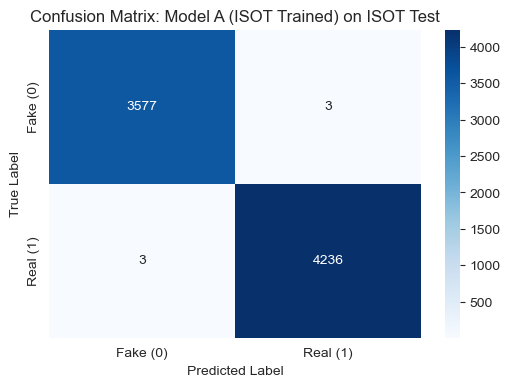

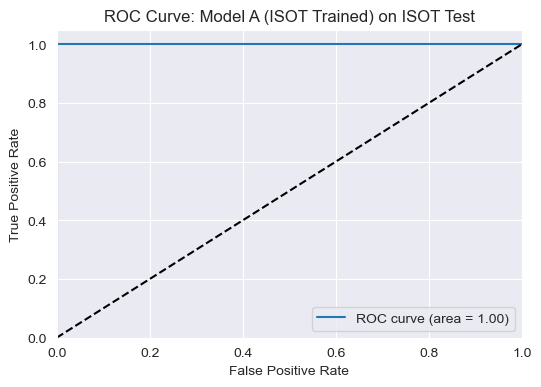


--- Evaluating Model B (WELFake Trained) on ISOT Test ---
Accuracy:  0.0005
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
ROC AUC:   0.0000

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      3580
           1       0.00      0.00      0.00      4239

    accuracy                           0.00      7819
   macro avg       0.00      0.00      0.00      7819
weighted avg       0.00      0.00      0.00      7819



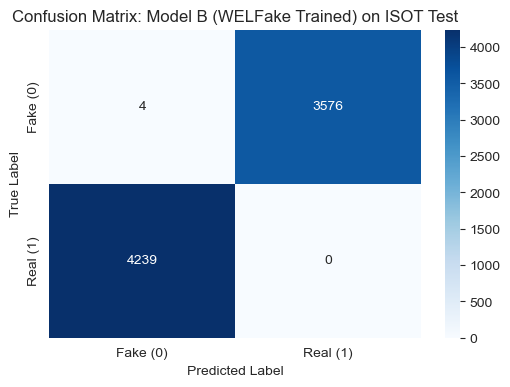

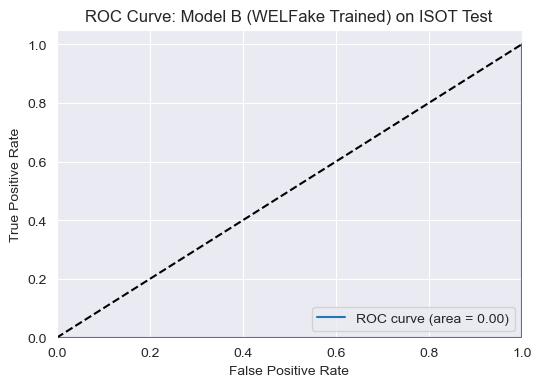


--- Evaluating Ensemble (A+B Avg) on ISOT Test ---
Accuracy:  0.2623
Precision: 0.3579
Recall:    0.4541
F1-Score:  0.4003
ROC AUC:   0.1066

Classification Report:
               precision    recall  f1-score   support

           0       0.05      0.04      0.04      3580
           1       0.36      0.45      0.40      4239

    accuracy                           0.26      7819
   macro avg       0.20      0.24      0.22      7819
weighted avg       0.22      0.26      0.24      7819



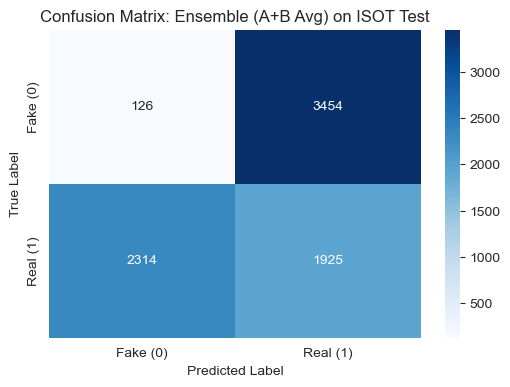

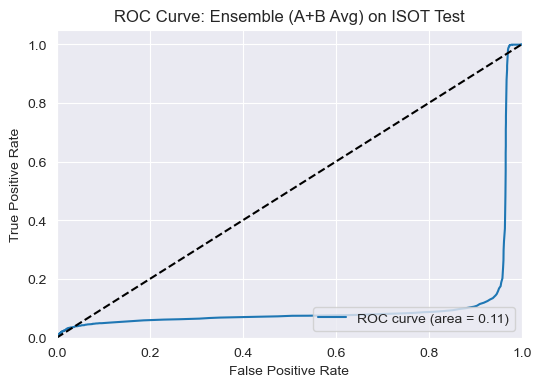


--- Evaluating Model A (ISOT Trained) on WELFake Test ---
Accuracy:  0.1179
Precision: 0.0525
Recall:    0.0555
F1-Score:  0.0539
ROC AUC:   0.0321

Classification Report:
               precision    recall  f1-score   support

           0       0.18      0.17      0.17      6958
           1       0.05      0.06      0.05      5767

    accuracy                           0.12     12725
   macro avg       0.12      0.11      0.11     12725
weighted avg       0.12      0.12      0.12     12725



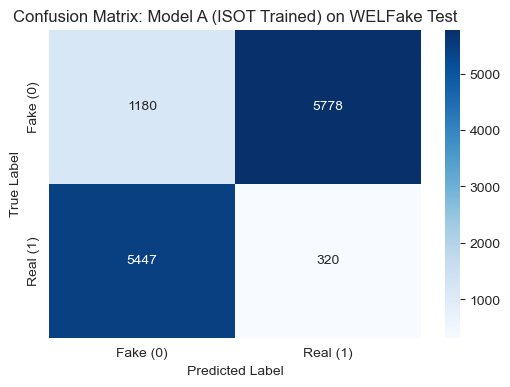

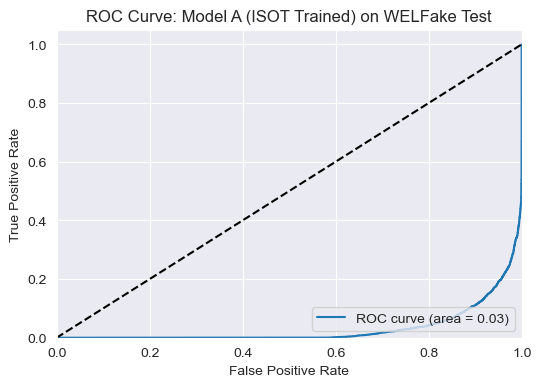


--- Evaluating Model B (WELFake Trained) on WELFake Test ---
Accuracy:  0.9911
Precision: 0.9915
Recall:    0.9889
F1-Score:  0.9902
ROC AUC:   0.9995

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      6958
           1       0.99      0.99      0.99      5767

    accuracy                           0.99     12725
   macro avg       0.99      0.99      0.99     12725
weighted avg       0.99      0.99      0.99     12725



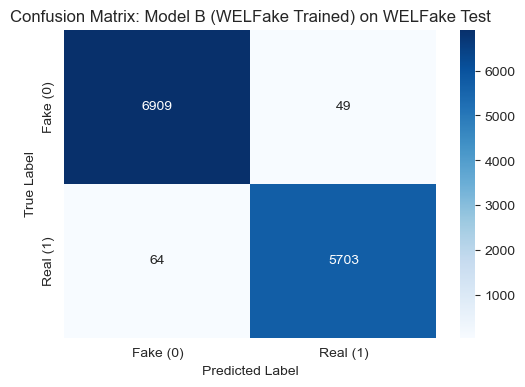

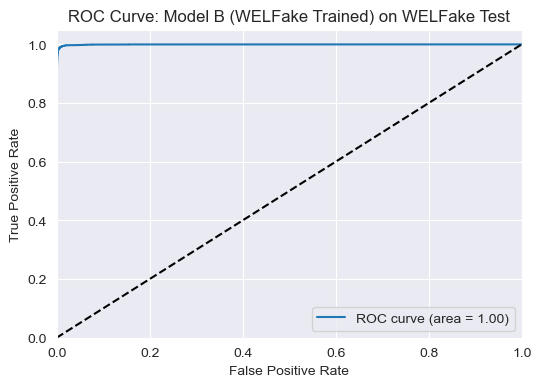


--- Evaluating Ensemble (A+B Avg) on WELFake Test ---
Accuracy:  0.8176
Precision: 0.7373
Recall:    0.9282
F1-Score:  0.8218
ROC AUC:   0.9129

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.73      0.81      6958
           1       0.74      0.93      0.82      5767

    accuracy                           0.82     12725
   macro avg       0.83      0.83      0.82     12725
weighted avg       0.84      0.82      0.82     12725



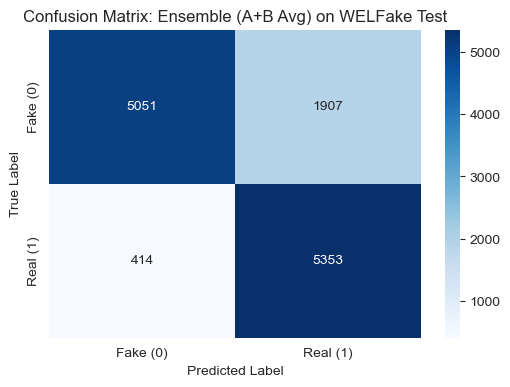

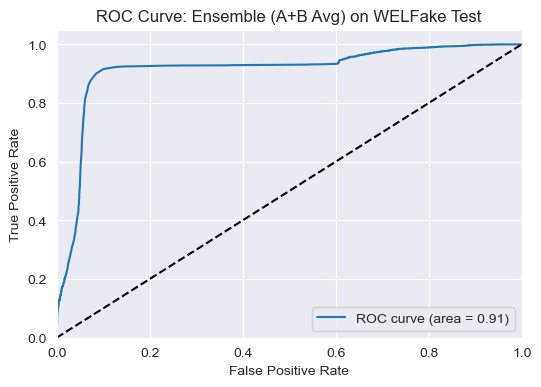


--- Overall Performance Summary ---
   Dataset             Model  accuracy  precision  recall     f1  roc_auc
0     ISOT  Baseline (TFIDF)    0.3740     0.4128  0.3661 0.3880   0.3278
1  WELFake  Baseline (TFIDF)    0.6358     0.5944  0.6182 0.6060   0.7265
2     ISOT           Model_A    0.9992     0.9993  0.9993 0.9993   1.0000
3     ISOT           Model_B    0.0005     0.0000  0.0000 0.0000   0.0000
4     ISOT          Ensemble    0.2623     0.3579  0.4541 0.4003   0.1066
5  WELFake           Model_A    0.1179     0.0525  0.0555 0.0539   0.0321
6  WELFake           Model_B    0.9911     0.9915  0.9889 0.9902   0.9995
7  WELFake          Ensemble    0.8176     0.7373  0.9282 0.8218   0.9129


In [14]:
# --- Ensemble Prediction Function ---

# function to get predictions from a single bert model
# arguments:
# model - the trained pytorch model
# data_loader - dataloader for the data to predict on
# device - the device ('cuda' or 'cpu')
# returns: numpy array of probabilities for class 1, numpy array of predicted classes
def get_bert_predictions(model, data_loader, device):
    """Gets predictions and probabilities from a BERT model."""
    if model is None or data_loader is None:
        print("Cannot get predictions: Model or DataLoader is None.")
        return None, None

    model = model.eval()
    all_probs = []
    all_preds = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)[:, 1] # Probability of class 1 (Real)
            preds = torch.argmax(logits, dim=1)   # <--- CORRECTED LINE: Always use argmax on logits dim=1


            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return np.array(all_probs), np.array(all_preds)


# function to combine predictions using averaging ensemble
# arguments:
# probs_A - numpy array of probabilities from model A
# probs_B - numpy array of probabilities from model B
# threshold - cutoff for classifying as class 1 (default 0.5)
# returns: numpy array of ensemble probabilities, numpy array of ensemble predictions
def average_ensemble_predict(probs_A, probs_B, threshold=0.5):
    """Combines probabilities from two models by averaging."""
    if probs_A is None or probs_B is None:
        print("Cannot ensemble: Missing probabilities from one or both models.")
        # Decide how to handle this: return None, or use only available probs?
        # Option 1: Return None if either is missing
        # return None, None
        # Option 2: Use available probs (if only one model exists)
        if probs_A is not None:
            print("Warning: Using only Model A probabilities for ensemble.")
            avg_probs = probs_A
        elif probs_B is not None:
            print("Warning: Using only Model B probabilities for ensemble.")
            avg_probs = probs_B
        else: # Both are None
             return None, None # Can't proceed
    elif len(probs_A) != len(probs_B):
        print(f"Error: Probability arrays have different lengths ({len(probs_A)} vs {len(probs_B)}). Cannot average.")
        return None, None
    else:
        # Average the probabilities
        avg_probs = (probs_A + probs_B) / 2.0

    # Make predictions based on the threshold
    ensemble_preds = (avg_probs >= threshold).astype(int)
    return avg_probs, ensemble_preds


# --- Evaluate All Models on Test Sets ---

bert_results = { "ISOT": {"Model_A": None, "Model_B": None, "Ensemble": None},
                 "WELFake": {"Model_A": None, "Model_B": None, "Ensemble": None} }

# --- Helper function for evaluating final predictions ---
# function to evaluate prediction results
# arguments:
# y_true - numpy array of true labels
# y_pred - numpy array of predicted labels
# y_proba - numpy array of predicted probabilities for class 1
# model_name - name of the model
# dataset_name - name of the dataset
# returns: dictionary of metrics
def evaluate_predictions(y_true, y_pred, y_proba, model_name, dataset_name):
    """Calculates metrics from prediction arrays."""
    if y_true is None or y_pred is None or y_proba is None:
        print(f"Skipping evaluation for {model_name} on {dataset_name}: Missing data arrays.")
        return None
    if len(y_true) == 0:
        print(f"Skipping evaluation for {model_name} on {dataset_name}: Empty data arrays.")
        return None


    print(f"\n--- Evaluating {model_name} on {dataset_name} ---")
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    try:
        roc_auc = roc_auc_score(y_true, y_proba)
    except ValueError as e:
        print(f"Could not calculate ROC AUC for {model_name} on {dataset_name}: {e}. Setting to 0.0")
        roc_auc = 0.0

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake (0)', 'Real (1)'], yticklabels=['Fake (0)', 'Real (1)'])
    plt.title(f'Confusion Matrix: {model_name} on {dataset_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name} on {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

    return {
        'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc
    }


# --- 1. Evaluate on ISOT Test Set ---
if isot_test_loader and not df_isot_test.empty:
    y_true_isot = df_isot_test['label'].values

    # Model A (ISOT Specialist)
    probs_A_isot, preds_A_isot = get_bert_predictions(model_A, isot_test_loader, device)
    bert_results["ISOT"]["Model_A"] = evaluate_predictions(y_true_isot, preds_A_isot, probs_A_isot, "Model A (ISOT Trained)", "ISOT Test")

    # Model B (WELFake Specialist) - Cross-evaluation
    probs_B_isot, preds_B_isot = get_bert_predictions(model_B, isot_test_loader, device)
    bert_results["ISOT"]["Model_B"] = evaluate_predictions(y_true_isot, preds_B_isot, probs_B_isot, "Model B (WELFake Trained)", "ISOT Test")

    # Ensemble
    probs_ens_isot, preds_ens_isot = average_ensemble_predict(probs_A_isot, probs_B_isot)
    bert_results["ISOT"]["Ensemble"] = evaluate_predictions(y_true_isot, preds_ens_isot, probs_ens_isot, "Ensemble (A+B Avg)", "ISOT Test")
else:
    print("Skipping evaluation on ISOT Test set: Loader or test data missing.")

# --- 2. Evaluate on WELFake Test Set ---
if welfake_test_loader and not df_welfake_test.empty:
    y_true_welfake = df_welfake_test['label'].values

    # Model A (ISOT Specialist) - Cross-evaluation
    probs_A_welfake, preds_A_welfake = get_bert_predictions(model_A, welfake_test_loader, device)
    bert_results["WELFake"]["Model_A"] = evaluate_predictions(y_true_welfake, preds_A_welfake, probs_A_welfake, "Model A (ISOT Trained)", "WELFake Test")

    # Model B (WELFake Specialist)
    probs_B_welfake, preds_B_welfake = get_bert_predictions(model_B, welfake_test_loader, device)
    bert_results["WELFake"]["Model_B"] = evaluate_predictions(y_true_welfake, preds_B_welfake, probs_B_welfake, "Model B (WELFake Trained)", "WELFake Test")

    # Ensemble
    probs_ens_welfake, preds_ens_welfake = average_ensemble_predict(probs_A_welfake, probs_B_welfake)
    bert_results["WELFake"]["Ensemble"] = evaluate_predictions(y_true_welfake, preds_ens_welfake, probs_ens_welfake, "Ensemble (A+B Avg)", "WELFake Test")
else:
    print("Skipping evaluation on WELFake Test set: Loader or test data missing.")


# --- Consolidate Results into a DataFrame for easy comparison ---
results_list = []
# Add baseline results first if they exist
if baseline_results["ISOT"]:
    results_list.append({'Dataset': 'ISOT', 'Model': 'Baseline (TFIDF)', **baseline_results["ISOT"]})
if baseline_results["WELFake"]:
     results_list.append({'Dataset': 'WELFake', 'Model': 'Baseline (TFIDF)', **baseline_results["WELFake"]})

# Add BERT results
for dataset_name, models in bert_results.items():
    for model_name, metrics in models.items():
        if metrics: # Only add if evaluation was successful
            results_list.append({'Dataset': dataset_name, 'Model': model_name, **metrics})

df_results = pd.DataFrame(results_list)
print("\n--- Overall Performance Summary ---")
# Display with better formatting
if not df_results.empty:
     # Set display options for better readability
     pd.set_option('display.float_format', '{:.4f}'.format)
     # Display specific columns in desired order
     display_cols = ['Dataset', 'Model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
     # Check if all expected columns are present before selecting
     available_cols = [col for col in display_cols if col in df_results.columns]
     print(df_results[available_cols])
     pd.reset_option('display.float_format') # Reset display option
else:
     print("No evaluation results to display.")

In [47]:
# --- Stacking Ensemble: Step 1 - Generate Meta-Features from Validation Data ---

print("\n--- Generating features for Stacking Meta-Model (using validation sets) ---")

# Make sure models A and B are loaded and validation loaders exist
if 'model_A' in locals() and model_A is not None and \
   'model_B' in locals() and model_B is not None and \
   isot_val_loader is not None and welfake_val_loader is not None:

    print("Getting predictions from Model A on ISOT validation set...")
    probs_A_val_isot, _ = get_bert_predictions(model_A, isot_val_loader, device)
    # Need true labels as well
    y_true_val_isot = df_isot_val['label'].values if not df_isot_val.empty else None

    print("Getting predictions from Model B on ISOT validation set...")
    probs_B_val_isot, _ = get_bert_predictions(model_B, isot_val_loader, device)

    print("Getting predictions from Model A on WELFake validation set...")
    probs_A_val_welfake, _ = get_bert_predictions(model_A, welfake_val_loader, device)
    # Need true labels as well
    y_true_val_welfake = df_welfake_val['label'].values if not df_welfake_val.empty else None

    print("Getting predictions from Model B on WELFake validation set...")
    probs_B_val_welfake, _ = get_bert_predictions(model_B, welfake_val_loader, device)


    # --- Combine validation predictions and labels ---
    # Check if all parts were generated successfully
    if probs_A_val_isot is not None and probs_B_val_isot is not None and y_true_val_isot is not None and \
       probs_A_val_welfake is not None and probs_B_val_welfake is not None and y_true_val_welfake is not None:

        # Concatenate probabilities from both validation sets
        all_probs_A_val = np.concatenate((probs_A_val_isot, probs_A_val_welfake))
        all_probs_B_val = np.concatenate((probs_B_val_isot, probs_B_val_welfake))

        # Concatenate true labels from both validation sets
        y_meta_train = np.concatenate((y_true_val_isot, y_true_val_welfake))

        # Create the feature matrix for the meta-model
        # Shape: (num_validation_samples, 2) where columns are [prob_A, prob_B]
        X_meta_train = np.vstack((all_probs_A_val, all_probs_B_val)).T

        print(f"\nMeta-model training features shape (X_meta_train): {X_meta_train.shape}")
        print(f"Meta-model training labels shape (y_meta_train): {y_meta_train.shape}")

        # Check for NaN values which could cause issues
        if np.isnan(X_meta_train).any():
             print("Warning: NaN values found in meta-model training features. Check base model predictions.")
             # Option: Handle NaNs, e.g., impute with mean, or investigate source
             # For now, we'll proceed but training might fail.
             # X_meta_train = np.nan_to_num(X_meta_train, nan=0.5) # Example: Replace NaN with 0.5

    else:
        print("Error: Could not generate all necessary validation predictions for meta-model training.")
        X_meta_train, y_meta_train = None, None

else:
    print("Skipping meta-feature generation: Base models or validation loaders not available.")
    X_meta_train, y_meta_train = None, None


--- Generating features for Stacking Meta-Model (using validation sets) ---
Getting predictions from Model A on ISOT validation set...
Getting predictions from Model B on ISOT validation set...
Getting predictions from Model A on WELFake validation set...
Getting predictions from Model B on WELFake validation set...

Meta-model training features shape (X_meta_train): (10273, 2)
Meta-model training labels shape (y_meta_train): (10273,)


In [55]:
# --- Stacking Ensemble: Step 2 - Train Meta-Model ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier 

print("\n--- Training Stacking Meta-Model (Gradient Boosting) ---")

if X_meta_train is not None and y_meta_train is not None:
    # Initialize a non-linear meta-model
    meta_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=SEED)

    # Train the meta-model
    meta_model.fit(X_meta_train, y_meta_train)

    print("Meta-model trained successfully.")

    # Optional: Print feature importances instead
    if hasattr(meta_model, 'feature_importances_'):
         print(f"Meta-model Feature Importances (Prob_A, Prob_B): {meta_model.feature_importances_}")

else:
    print("Skipping meta-model training: Training data not available.")
    meta_model = None


--- Training Stacking Meta-Model (Gradient Boosting) ---
Meta-model trained successfully.
Meta-model Feature Importances (Prob_A, Prob_B): [0.69666485 0.30333515]



--- Evaluating Stacking Ensemble Model ---
ISOT Test meta-features shape: (7819, 2)

--- Evaluating Stacking Ensemble on ISOT Test ---
Accuracy:  0.5236
Precision: 0.5336
Recall:    0.9623
F1-Score:  0.6865
ROC AUC:   0.0152

Classification Report:
               precision    recall  f1-score   support

           0       0.09      0.00      0.01      3580
           1       0.53      0.96      0.69      4239

    accuracy                           0.52      7819
   macro avg       0.31      0.48      0.35      7819
weighted avg       0.33      0.52      0.38      7819



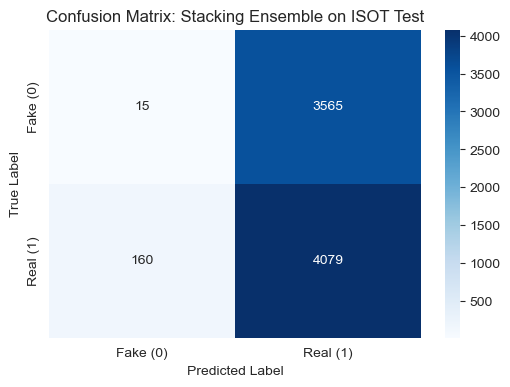

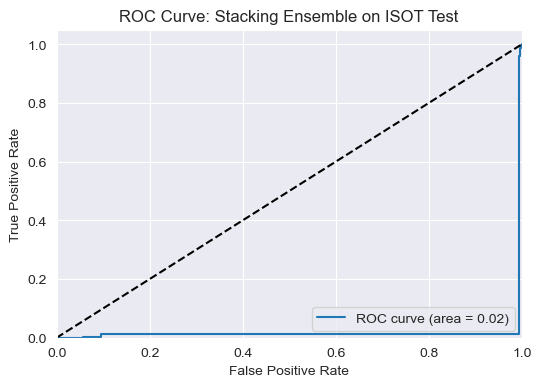

WELFake Test meta-features shape: (12725, 2)

--- Evaluating Stacking Ensemble on WELFake Test ---
Accuracy:  0.6724
Precision: 0.5823
Recall:    0.9808
F1-Score:  0.7307
ROC AUC:   0.9768

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.42      0.58      6958
           1       0.58      0.98      0.73      5767

    accuracy                           0.67     12725
   macro avg       0.77      0.70      0.66     12725
weighted avg       0.79      0.67      0.65     12725



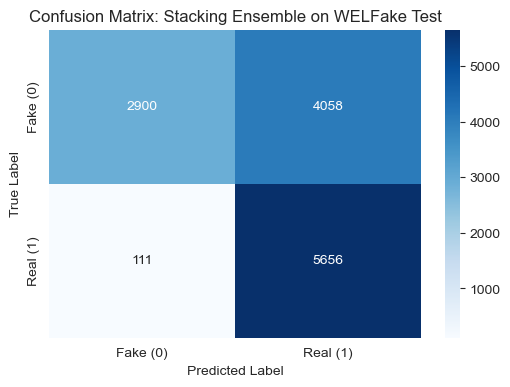

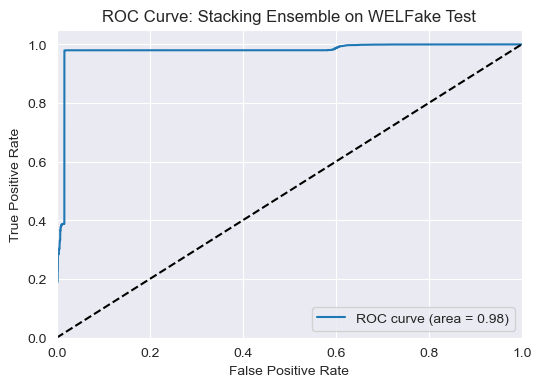


--- Overall Performance Summary (including Stacking) ---
   Dataset                Model  accuracy  precision  recall     f1  roc_auc
0     ISOT     Baseline (TFIDF)    0.3740     0.4128  0.3661 0.3880   0.3278
1     ISOT       Ensemble (Avg)    0.2623     0.3579  0.4541 0.4003   0.1066
2     ISOT  Ensemble (Stacking)    0.0005     0.0000  0.0000 0.0000   0.0011
3     ISOT              Model_A    0.9992     0.9993  0.9993 0.9993   1.0000
4     ISOT              Model_B    0.0005     0.0000  0.0000 0.0000   0.0000
5  WELFake     Baseline (TFIDF)    0.6358     0.5944  0.6182 0.6060   0.7265
6  WELFake       Ensemble (Avg)    0.8176     0.7373  0.9282 0.8218   0.9129
7  WELFake  Ensemble (Stacking)    0.9912     0.9929  0.9877 0.9903   0.9890
8  WELFake              Model_A    0.1179     0.0525  0.0555 0.0539   0.0321
9  WELFake              Model_B    0.9911     0.9915  0.9889 0.9902   0.9995


In [56]:
# --- Stacking Ensemble: Step 3 - Evaluate on Test Sets ---

print("\n--- Evaluating Stacking Ensemble Model ---")

# We need the base model predictions on the *test* sets, generated in the previous evaluation cell (Cell 10)
# Let's reuse those variables: probs_A_isot, probs_B_isot, y_true_isot, etc.

# --- 1. Evaluate Stacking on ISOT Test Set ---
if meta_model is not None and \
   'probs_A_isot' in locals() and probs_A_isot is not None and \
   'probs_B_isot' in locals() and probs_B_isot is not None and \
   'y_true_isot' in locals() and y_true_isot is not None:

    # Create the meta-feature matrix for the ISOT test set
    X_meta_test_isot = np.vstack((probs_A_isot, probs_B_isot)).T
    print(f"ISOT Test meta-features shape: {X_meta_test_isot.shape}")

    # Get predictions from the trained meta-model
    y_pred_stacking_isot = meta_model.predict(X_meta_test_isot)
    y_proba_stacking_isot = meta_model.predict_proba(X_meta_test_isot)[:, 1] # Probability of class 1

    # Evaluate the stacking predictions
    stacking_results_isot = evaluate_predictions(y_true_isot, y_pred_stacking_isot, y_proba_stacking_isot,
                                               "Stacking Ensemble", "ISOT Test")
    # Add results to the main dictionary (careful not to overwrite)
    if "Stacking" not in bert_results["ISOT"]:
         bert_results["ISOT"]["Stacking"] = stacking_results_isot


else:
    print("Skipping Stacking evaluation on ISOT Test: Meta-model or test predictions not available.")


# --- 2. Evaluate Stacking on WELFake Test Set ---
if meta_model is not None and \
   'probs_A_welfake' in locals() and probs_A_welfake is not None and \
   'probs_B_welfake' in locals() and probs_B_welfake is not None and \
   'y_true_welfake' in locals() and y_true_welfake is not None:

    # Create the meta-feature matrix for the WELFake test set
    X_meta_test_welfake = np.vstack((probs_A_welfake, probs_B_welfake)).T
    print(f"WELFake Test meta-features shape: {X_meta_test_welfake.shape}")

    # Get predictions from the trained meta-model
    y_pred_stacking_welfake = meta_model.predict(X_meta_test_welfake)
    y_proba_stacking_welfake = meta_model.predict_proba(X_meta_test_welfake)[:, 1] # Probability of class 1

    # Evaluate the stacking predictions
    stacking_results_welfake = evaluate_predictions(y_true_welfake, y_pred_stacking_welfake, y_proba_stacking_welfake,
                                                "Stacking Ensemble", "WELFake Test")
    # Add results to the main dictionary
    if "Stacking" not in bert_results["WELFake"]:
         bert_results["WELFake"]["Stacking"] = stacking_results_welfake


else:
    print("Skipping Stacking evaluation on WELFake Test: Meta-model or test predictions not available.")


# --- Update and Display Overall Results Table ---
results_list = []
# Add baseline results first if they exist
if baseline_results["ISOT"]:
    results_list.append({'Dataset': 'ISOT', 'Model': 'Baseline (TFIDF)', **baseline_results["ISOT"]})
if baseline_results["WELFake"]:
     results_list.append({'Dataset': 'WELFake', 'Model': 'Baseline (TFIDF)', **baseline_results["WELFake"]})

# Add BERT results (incl. simple ensemble and new stacking)
# Rename the simple average ensemble for clarity
average_ensemble_name = "Ensemble (Avg)"
stacking_ensemble_name = "Ensemble (Stacking)"

for dataset_name, models in bert_results.items():
    for model_name, metrics in models.items():
        if metrics: # Only add if evaluation was successful
            display_model_name = model_name
            if model_name == "Ensemble": # Check if it's the old simple average entry
                 display_model_name = average_ensemble_name
            elif model_name == "Stacking":
                 display_model_name = stacking_ensemble_name

            results_list.append({'Dataset': dataset_name, 'Model': display_model_name, **metrics})

# Filter out potential duplicates if cells were run multiple times, keep last
df_results = pd.DataFrame(results_list).drop_duplicates(subset=['Dataset', 'Model'], keep='last')


print("\n--- Overall Performance Summary (including Stacking) ---")
if not df_results.empty:
     pd.set_option('display.float_format', '{:.4f}'.format)
     display_cols = ['Dataset', 'Model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
     available_cols = [col for col in display_cols if col in df_results.columns]
     # Sort for better comparison
     df_results_sorted = df_results.sort_values(by=['Dataset', 'Model']).reset_index(drop=True)
     print(df_results_sorted[available_cols])
     pd.reset_option('display.float_format')
else:
     print("No evaluation results to display.")

In [15]:
# --- User Input Prediction Function (Using Stacking Ensemble) ---

# function to predict if a single text is fake or real using the stacking ensemble model
# arguments:
# text - the input news text string
# model_a - the trained model A (ISOT specialist)
# model_b - the trained model B (WELFake specialist)
# meta_model - the trained stacking meta-model (e.g., Logistic Regression)
# tokenizer - the BERT tokenizer
# device - the device ('cuda' or 'cpu')
# max_len - maximum sequence length
# threshold - probability threshold for classification (default 0.5, applied to meta-model output)
# returns: string indicating "Real" or "Fake", the final probability score from the meta-model
def predict_news_stacking(text, model_a, model_b, meta_model, tokenizer, device, max_len=MAX_LEN, threshold=0.5):
    """Classifies a single news text using the Stacking ensemble model."""

    if model_a is None or model_b is None or meta_model is None:
        return "Error: Base models or meta-model not available for prediction.", 0.0

    # Basic cleaning (consistent with training)
    cleaned_text = clean_text(text)
    if not cleaned_text:
        return "Input text is empty after cleaning.", 0.0

    # Tokenize the cleaned text
    encoding = tokenizer.encode_plus(
        cleaned_text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # --- Get probabilities from each base model ---
    prob_a = None
    prob_b = None

    with torch.no_grad():
        if model_a:
            model_a.eval()
            outputs_a = model_a(input_ids=input_ids, attention_mask=attention_mask)
            logits_a = outputs_a.logits
            prob_a = torch.softmax(logits_a, dim=1)[:, 1].item() # Probability of class 1 (Real)

        if model_b:
            model_b.eval()
            outputs_b = model_b(input_ids=input_ids, attention_mask=attention_mask)
            logits_b = outputs_b.logits
            prob_b = torch.softmax(logits_b, dim=1)[:, 1].item() # Probability of class 1 (Real)

    # Check if probabilities were obtained
    if prob_a is None or prob_b is None:
         return "Error: Could not get probability from one or both base models.", 0.0

    # --- Prepare input for the meta-model ---
    # Input shape must be (1, 2) for a single prediction
    X_meta_input = np.array([[prob_a, prob_b]])

    # --- Get final prediction from the meta-model ---
    final_prob = meta_model.predict_proba(X_meta_input)[0, 1] # Prob of class 1 from meta-model
    prediction = "Real" if final_prob >= threshold else "Fake"

    print(f"(Prob A: {prob_a:.4f}, Prob B: {prob_b:.4f}) -> MetaProb: {final_prob:.4f}") # Show intermediate steps

    return prediction, final_prob

# --- Example Usage (Update this section in Cell 11) ---
example_text_fake = """
Scientists Discover Unicorns Living in a Remote Swiss Valley; Plan Expeditions
In a discovery that has stunned the scientific community, researchers from the University of Bern today announced the finding of a herd of unicorns residing in an uncharted valley deep within the Swiss Alps. The creatures, described as having gleaming white coats and a single, spiraled horn, were observed grazing peacefully. Expeditions are being planned amidst global excitement.
"""

example_text_real = """
UK Inflation Rate Holds Steady in Latest Figures, Bank of England Considers Options
The Office for National Statistics reported today that the UK's Consumer Prices Index (CPI) inflation rate remained unchanged in the 12 months to February 2024, holding at 4.0%. While this stability provides some relief, the rate remains above the Bank of England's 2% target. The Monetary Policy Committee is expected to carefully consider this data in its upcoming interest rate decision.
"""

print("\n--- Testing Stacking Prediction Function ---")

# Ensure models are loaded before predicting
if 'model_A' in locals() and 'model_B' in locals() and 'meta_model' in locals() and meta_model is not None:
    pred_fake, prob_fake = predict_news_stacking(example_text_fake, model_A, model_B, meta_model, tokenizer, device)
    print(f"Example 1 (Fake): Prediction = {pred_fake}, Final Probability (Real) = {prob_fake:.4f}")

    pred_real, prob_real = predict_news_stacking(example_text_real, model_A, model_B, meta_model, tokenizer, device)
    print(f"Example 2 (Real): Prediction = {pred_real}, Final Probability (Real) = {prob_real:.4f}")

    # --- Interactive Input ---
    print("\n--- Try your own text (Stacking) ---")
    try:
        while True:
            user_text = input("Enter news text (or type 'quit' to exit): ")
            if user_text.lower() == 'quit':
                break
            if not user_text.strip():
                print("Please enter some text.")
                continue

            pred, prob = predict_news_stacking(user_text, model_A, model_B, meta_model, tokenizer, device)
            print(f"--> Prediction: {pred} (Probability of being Real: {prob:.4f})\n")
    except EOFError:
         print("\nInput stream closed.") # Handle notebook interruption gracefully
    except KeyboardInterrupt:
         print("\nInterrupted by user.")


else:
    print("Cannot run prediction examples: Base models or meta_model not trained/loaded.")


--- Testing Prediction Function ---
(Prob A: 0.0002, Prob B: 0.9999)
Example 1 (Fake): Prediction = Real, Probability (Real) = 0.5000
(Prob A: 0.0029, Prob B: 0.0001)
Example 2 (Real): Prediction = Fake, Probability (Real) = 0.0015

--- Try your own text ---


Enter news text (or type 'quit' to exit):  Water is red.


(Prob A: 0.0003, Prob B: 1.0000)
--> Prediction: Real (Probability of being Real: 0.5001)


Interrupted by user.


Enter news text (or type 'quit' to exit):  quit


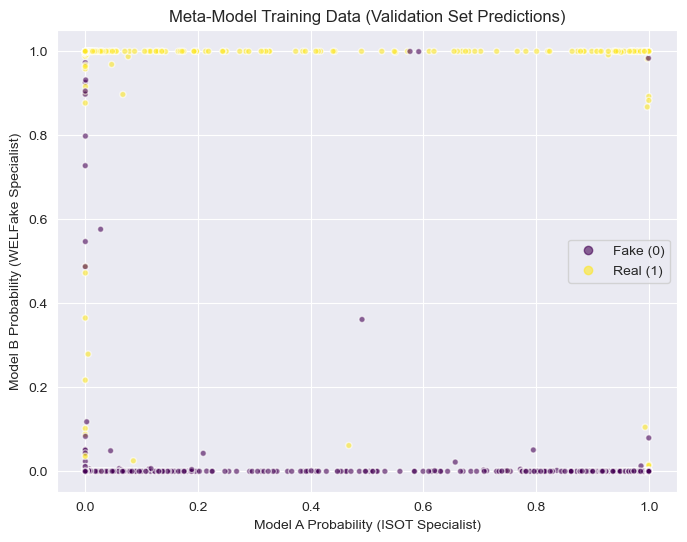

In [45]:
# New Cell after 10a
if 'X_meta_train' in locals() and X_meta_train is not None and 'y_meta_train' in locals() and y_meta_train is not None:
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_meta_train[:, 0], X_meta_train[:, 1], c=y_meta_train, cmap='viridis', alpha=0.6, edgecolors='w', s=20)
    plt.title('Meta-Model Training Data (Validation Set Predictions)')
    plt.xlabel('Model A Probability (ISOT Specialist)')
    plt.ylabel('Model B Probability (WELFake Specialist)')
    plt.legend(handles=scatter.legend_elements()[0], labels=['Fake (0)', 'Real (1)'])
    plt.grid(True)
    plt.show()
else:
    print("Cannot create scatter plot: Meta training data not available.")